# RF Binding Ranking

## Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [50]:
# Load all datasets independently
print("Loading datasets...")

# Load mutation data
mutation_df = pd.read_csv("mutation/mutation-all.csv")
print(f"Mutation data shape: {mutation_df.shape}")

# Load sidechain angles data
sidechain_df = pd.read_csv("sidechain_angles.csv", index_col=0)
print(f"Sidechain angles data shape: {sidechain_df.shape}")

# Load structure data
ca_distances = pd.read_csv("tmalign/residues_full.csv")
print(f"Structure data shape: {ca_distances.shape}")

# Load binding affinity data
binding_scores = pd.read_csv("mutation/binding-affinity.csv")
print(f"Binding affinity data shape: {binding_scores.shape}")

Loading datasets...
Mutation data shape: (48, 70)
Sidechain angles data shape: (49, 30)
Structure data shape: (55, 223)
Binding affinity data shape: (74, 7)


## Process Mutation Data

In [51]:
# Process each dataset independently
print("\nProcessing datasets independently...")

# 1. Process mutation data
print("\n1. Processing mutation data...")
variant_mapping = {
    "Wuhan": "Wuhan-A",
    "A": "Alpha-B.1.1.7",
    "B": "Beta-B.1.351",
    "D": "Delta-B.1.617.2",
    "G": "Gamma-P.1",
    "O1": "Omicron-BA.1",
    "O2": "Omicron-BA.1.1",
    "O3": "Omicron-BA.2.12.1",
    "O4": "Omicron-BA.5.2.1",
}

binding_scores["variant"] = binding_scores["Protein -protein complex"].str.split("-").str[0].map(variant_mapping)
binding_scores = binding_scores[["variant", "Binding affinity"]].groupby("variant").min().reset_index().set_index("variant")
binding_scores = binding_scores["Binding affinity"]

mutation_data = mutation_df.copy()
for var in mutation_data['variant'].unique():
    mutation_data["Against " + var] = mutation_data["variant"].map(binding_scores).apply(
        lambda x: 0 if x == binding_scores[var] else (1 if x > binding_scores[var] else -1)
    )

print(f"Processed mutation data shape: {mutation_data.shape}")
print(f"Mutation data columns: {list(mutation_data.columns[:10])}...")
mutation_data.head()


Processing datasets independently...

1. Processing mutation data...
Processed mutation data shape: (48, 76)
Mutation data columns: ['sequence', 'variant', 'D614G', 'N856S', 'G1124V', 'T19R', 'T95I', 'G142D', 'E156G', 'F157-']...


,sequence,variant,D614G,N856S,G1124V,T19R,T95I,G142D,E156G,F157-,...,N969K,L981F,A243S,A829T,Against Beta-B.1.351,Against Delta-B.1.617.2,Against Gamma-P.1,Against Omicron-BA.1.1,Against Omicron-BA.1,Against Wuhan-A
0,Beta-B.1.351-S1,Beta-B.1.351,1,1,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1
1,Beta-B.1.351-S2,Beta-B.1.351,1,1,1,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1
2,Beta-B.1.351-S3,Beta-B.1.351,1,1,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1
3,Beta-B.1.351-S4,Beta-B.1.351,1,1,1,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1
4,Beta-B.1.351-S5,Beta-B.1.351,1,1,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,1,-1,-1


## Process Sidechain Data

In [52]:
# 2. Process sidechain angles data
print("\n2. Processing sidechain angles data...")

# Extract variant names from sample names
sidechain_data = sidechain_df.copy()
sidechain_data['variant'] = [sample.split('-S')[0] if '-S' in sample else sample for sample in sidechain_data.index]
sidechain_data = sidechain_data.reset_index().rename(columns={'index': 'sequence'})

# Handle missing values
angle_cols = [col for col in sidechain_data.columns if any(col.endswith(suffix) for suffix in ['_Theta', '_Phi', '_Chi1'])]
sidechain_data[angle_cols] = sidechain_data[angle_cols].replace('N/A', np.nan).astype(float)
sidechain_data[angle_cols] = sidechain_data[angle_cols].fillna(sidechain_data[angle_cols].mean())

print(f"Processed sidechain data shape: {sidechain_data.shape}")
print(f"Sidechain angle columns: {len(angle_cols)} features")


2. Processing sidechain angles data...
Processed sidechain data shape: (49, 32)
Sidechain angle columns: 30 features


## Process Structure Data

In [53]:
# 3. Process structure data with sliding window features
print("\n3. Processing structure data with sliding window features...")

def sliding_window_features(signal, window_size=10, step=5):
    """Apply sliding window transformation to extract statistical features"""
    features = []
    for start in range(0, len(signal) - window_size + 1, step):
        window = signal[start:start + window_size]
        stats = [start, np.mean(window), np.std(window), np.min(window), np.max(window)]
        features.append(stats)
    return np.array(features)

# Extract residue columns
residue_cols = [col for col in ca_distances.columns if col.startswith('residue_')]
print(f"Found {len(residue_cols)} residue columns")

# Apply sliding window transformation to each sequence
sliding_window_data = []
for idx, row in ca_distances.iterrows():
    sequence_id = row['sequence']
    residue_distances = row[residue_cols].values.astype(float)
    
    window_features = sliding_window_features(residue_distances, window_size=10, step=5)
    
    feature_dict = {'sequence': sequence_id}
    for i, feature_val in enumerate(window_features):
        feature_dict[f'sw_feature_{319 + int(feature_val[0])}_mean'] = feature_val[1]
        feature_dict[f'sw_feature_{319 + int(feature_val[0])}_std'] = feature_val[2]
        feature_dict[f'sw_feature_{319 + int(feature_val[0])}_min'] = feature_val[3]
        feature_dict[f'sw_feature_{319 + int(feature_val[0])}_max'] = feature_val[4]
    
    sliding_window_data.append(feature_dict)

structure_data = pd.DataFrame(sliding_window_data)
print(f"Processed structure data shape: {structure_data.shape}")


3. Processing structure data with sliding window features...
Found 222 residue columns
Processed structure data shape: (55, 173)


## Combine Datasets

In [54]:
# 4. Combine all datasets
print("\n4. Combining all datasets...")

# Start with mutation data
combined_df = mutation_data.copy()

# Merge with structure data
combined_df = combined_df.merge(structure_data, on="sequence", how="left")
print(f"After merging structure data: {combined_df.shape}")

# Merge with sidechain data
combined_df = combined_df.merge(sidechain_data, on=["sequence", "variant"], how="left")
print(f"After merging sidechain data: {combined_df.shape}")

# Remove rows with missing data
combined_df = combined_df.dropna()
print(f"Final combined dataset shape: {combined_df.shape}")

# Display dataset info
print(f"\nDataset summary:")
print(f"- Total samples: {len(combined_df)}")
print(f"- Total features: {len([col for col in combined_df.columns if col not in ['sequence', 'variant'] + ['Against ' + var for var in combined_df['variant'].unique()]])}")
print(f"- Variants: {list(combined_df['variant'].unique())}")

combined_df.head()


4. Combining all datasets...
After merging structure data: (48, 248)
After merging sidechain data: (48, 278)
Final combined dataset shape: (48, 278)

Dataset summary:
- Total samples: 48
- Total features: 270
- Variants: ['Beta-B.1.351', 'Delta-B.1.617.2', 'Gamma-P.1', 'Omicron-BA.1.1', 'Omicron-BA.1', 'Wuhan-A']


,sequence,variant,D614G,N856S,G1124V,T19R,T95I,G142D,E156G,F157-,...,500_Chi1,501_Theta,501_Phi,501_Chi1,502_Theta,502_Phi,502_Chi1,505_Theta,505_Phi,505_Chi1
0,Beta-B.1.351-S1,Beta-B.1.351,1,1,0,0,0,0,0,0,...,54.145790,114.823099,-23.491859,-69.305250,0.0,0.0,-69.456926,128.537686,-40.669512,-68.198973
1,Beta-B.1.351-S2,Beta-B.1.351,1,1,1,0,0,0,0,0,...,53.855015,114.527291,-23.299859,-68.754149,0.0,0.0,-69.456926,128.654896,-40.699352,-68.709942
2,Beta-B.1.351-S3,Beta-B.1.351,1,1,0,0,0,0,0,0,...,53.476365,112.710472,-25.079444,-73.260433,0.0,0.0,-69.456926,128.075535,-41.130523,-69.247606
3,Beta-B.1.351-S4,Beta-B.1.351,1,1,1,0,0,0,0,0,...,53.855015,114.527291,-23.299859,-68.754149,0.0,0.0,-69.456926,128.654896,-40.699352,-68.709942
4,Beta-B.1.351-S5,Beta-B.1.351,1,1,0,0,0,0,0,0,...,53.855015,114.527291,-23.299859,-68.754149,0.0,0.0,-69.456926,128.654896,-40.699352,-68.709942


## Random Forest Model

In [55]:
# Random Forest model functions
def convert_to_classes(y):
    """Convert -1, 1 to class indices 0, 1"""
    return (y + 1) // 2  # -1->0, 1->1

def convert_from_classes(class_indices):
    """Convert class indices 0, 1 back to -1, 1"""
    return class_indices * 2 - 1  # 0->-1, 1->1

def train_single_rf_model(X_train, y_train, X_test, y_test, rf_params=None):
    if rf_params is None:
        rf_params = {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}
    
    # Filter out rows where y == 0
    train_mask = y_train != 0
    test_mask = y_test != 0
    
    X_train_filtered = X_train[train_mask]
    y_train_filtered = y_train[train_mask]
    X_test_filtered = X_test[test_mask]
    y_test_filtered = y_test[test_mask]
    
    # Convert targets to class indices for Random Forest
    y_train_classes = convert_to_classes(y_train_filtered)
    y_test_classes = convert_to_classes(y_test_filtered)
    
    # Create and train Random Forest classifier
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train_filtered, y_train_classes)
    
    # Make predictions
    train_pred_classes = model.predict(X_train_filtered)
    test_pred_classes = model.predict(X_test_filtered)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train_classes, train_pred_classes)
    test_accuracy = accuracy_score(y_test_classes, test_pred_classes)
    
    # Convert back to original labels (-1, 1)
    train_pred_original = convert_from_classes(train_pred_classes)
    test_pred_original = convert_from_classes(test_pred_classes)
    
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_predictions': test_pred_original,
        'test_actual': y_test_filtered,
        'n_train_samples': len(y_train_filtered),
        'n_test_samples': len(y_test_filtered),
        'feature_importance': model.feature_importances_
    }

## Comprehensive Validation Functions

In [56]:
# Define variant order
ORDER = ["Wuhan-A", "Beta-B.1.351", "Alpha-B.1.1.7", "Gamma-P.1", "Omicron-BA.1", "Delta-B.1.617.2", "Omicron-BA.2.12.1", "Omicron-BA.5.2.1", "Omicron-BA.1.1"]

def comprehensive_rf_validation(X_train, y_train, X_test, y_test, rf_params=None):
    """
    Comprehensive Random Forest validation with multiple metrics and cross-validation
    """
    if rf_params is None:
        rf_params = {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}
    
    # Filter out rows where y == 0
    train_mask = y_train != 0
    test_mask = y_test != 0
    
    X_train_filtered = X_train[train_mask]
    y_train_filtered = y_train[train_mask]
    X_test_filtered = X_test[test_mask]
    y_test_filtered = y_test[test_mask]
    
    if len(X_train_filtered) == 0 or len(X_test_filtered) == 0:
        return None
    
    # Convert targets to class indices for Random Forest
    y_train_classes = convert_to_classes(y_train_filtered)
    y_test_classes = convert_to_classes(y_test_filtered)
    
    # Create and train Random Forest
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train_filtered, y_train_classes)
    
    # Predictions
    train_pred_classes = model.predict(X_train_filtered)
    test_pred_classes = model.predict(X_test_filtered)
    
    # Calculate comprehensive metrics
    train_accuracy = accuracy_score(y_train_classes, train_pred_classes)
    test_accuracy = accuracy_score(y_test_classes, test_pred_classes)
    
    # Only calculate precision/recall/f1 if both classes are present
    test_precision = test_recall = test_f1 = 0.0
    if len(np.unique(y_test_classes)) > 1 and len(np.unique(test_pred_classes)) > 1:
        test_precision = precision_score(y_test_classes, test_pred_classes, average='weighted', zero_division=0)
        test_recall = recall_score(y_test_classes, test_pred_classes, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test_classes, test_pred_classes, average='weighted', zero_division=0)
    
    # Cross-validation on training data (if enough samples)
    cv_scores = []
    if len(X_train_filtered) >= 6:  # Need at least 6 samples for 3-fold CV
        try:
            cv = StratifiedKFold(n_splits=min(3, len(X_train_filtered)//2), shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_filtered, y_train_classes, cv=cv, scoring='accuracy')
        except:
            cv_scores = []
    
    # Convert back to original labels
    test_pred_original = convert_from_classes(test_pred_classes)
    
    # Mean absolute difference
    mean_diff = np.mean(np.abs(test_pred_original - y_test_filtered))
    
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'cv_mean': np.mean(cv_scores) if len(cv_scores) > 0 else 0.0,
        'cv_std': np.std(cv_scores) if len(cv_scores) > 0 else 0.0,
        'mean_diff': mean_diff,
        'test_predictions': test_pred_original,
        'test_actual': y_test_filtered,
        'n_train_samples': len(y_train_filtered),
        'n_test_samples': len(y_test_filtered),
        'confusion_matrix': confusion_matrix(y_test_classes, test_pred_classes).tolist(),
        'feature_importance': model.feature_importances_
    }

## Model Training & Validation

In [57]:
# Test different Random Forest configurations
rf_configs = [
    {'name': 'RF_default', 'params': {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}},
    {'name': 'RF_deep', 'params': {'n_estimators': 200, 'max_depth': 20, 'random_state': 42}},
    {'name': 'RF_shallow', 'params': {'n_estimators': 50, 'max_depth': 5, 'random_state': 42}},
]

# Dictionary to store comprehensive metrics for heatmap
heatmap_data = {}
detailed_results = {}

print("Running comprehensive Random Forest validation with multiple configurations...")
print("=" * 70)

for validation in ORDER:
    VALIDATION_VARIANT = validation
    if VALIDATION_VARIANT not in combined_df["variant"].unique():
        continue
    
    X = combined_df.drop(columns=["sequence", "variant"] + ["Against " + var for var in combined_df['variant'].unique()]).values.astype(float)
    y = combined_df["Against " + VALIDATION_VARIANT].values.astype(float)
    
    for var in combined_df["variant"].unique():
        if var == VALIDATION_VARIANT:
            continue
            
        mask = (combined_df["variant"] == VALIDATION_VARIANT) | (combined_df["variant"] == var)
        X_train = X[~mask]
        y_train = y[~mask]
        X_test = X[mask]
        y_test = y[mask]
            
        if len(set(y_train)) == 1:
            continue
        
        print(f"\nProcessing {VALIDATION_VARIANT} vs {var}: {X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}")
        
        best_config = None
        best_accuracy = -1
        
        # Test each Random Forest configuration
        for config in rf_configs:
            result = comprehensive_rf_validation(X_train, y_train, X_test, y_test, config['params'])
            
            if result is not None:
                print(f"  {config['name']}: Accuracy={result['test_accuracy']:.3f}, F1={result['test_f1']:.3f}, CV={result['cv_mean']:.3f}±{result['cv_std']:.3f}")
                
                # Track best configuration based on test accuracy
                if result['test_accuracy'] > best_accuracy:
                    best_accuracy = result['test_accuracy']
                    best_config = config['name']
                    heatmap_data[(VALIDATION_VARIANT, var)] = result['mean_diff']
                    detailed_results[(VALIDATION_VARIANT, var)] = result
        
        if best_config:
            print(f"  → Best config: {best_config} (Accuracy: {best_accuracy:.3f})")
        else:
            print(f"  → No valid predictions for {VALIDATION_VARIANT} vs {var}")

print("\n" + "=" * 70)
print("Completed Random Forest validation with hyperparameter testing!")

Running comprehensive Random Forest validation with multiple configurations...

Processing Wuhan-A vs Beta-B.1.351: (32, 270), (32,), (16, 270), (16,)
  RF_default: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RF_deep: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RF_shallow: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  → Best config: RF_default (Accuracy: 1.000)

Processing Wuhan-A vs Delta-B.1.617.2: (32, 270), (32,), (16, 270), (16,)
  RF_default: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RF_deep: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RF_shallow: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  → Best config: RF_default (Accuracy: 1.000)

Processing Wuhan-A vs Omicron-BA.1.1: (32, 270), (32,), (16, 270), (16,)
  RF_default: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RF_deep: Accuracy=1.000, F1=0.000, CV=0.970±0.043
  RF_shallow: Accuracy=1.000, F1=0.000, CV=0.909±0.129
  → Best config: RF_default (Accuracy: 1.000)

Processing Wuhan-A vs Omicron-BA.1: (32, 270), (32,), (16, 270), (16,)
  RF

## Validation Visualization

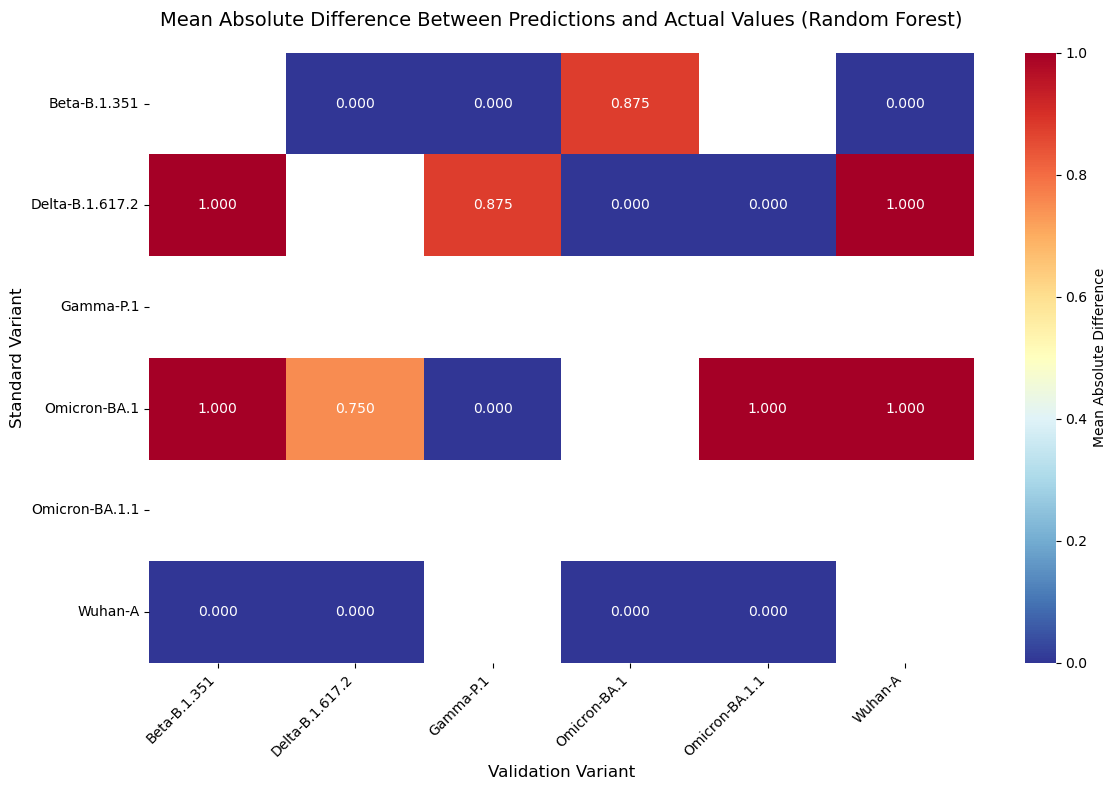


HEATMAP SUMMARY:
Beta-B.1.351 vs Delta-B.1.617.2: 0.0000
Beta-B.1.351 vs Gamma-P.1: 0.0000
Beta-B.1.351 vs Omicron-BA.1: 1.7500
Beta-B.1.351 vs Wuhan-A: 0.0000
Delta-B.1.617.2 vs Beta-B.1.351: 2.0000
Delta-B.1.617.2 vs Gamma-P.1: 1.7500
Delta-B.1.617.2 vs Omicron-BA.1: 0.0000
Delta-B.1.617.2 vs Omicron-BA.1.1: 0.0000
Delta-B.1.617.2 vs Wuhan-A: 2.0000
Omicron-BA.1 vs Beta-B.1.351: 2.0000
Omicron-BA.1 vs Delta-B.1.617.2: 1.5000
Omicron-BA.1 vs Gamma-P.1: 0.0000
Omicron-BA.1 vs Omicron-BA.1.1: 2.0000
Omicron-BA.1 vs Wuhan-A: 2.0000
Wuhan-A vs Beta-B.1.351: 0.0000
Wuhan-A vs Delta-B.1.617.2: 0.0000
Wuhan-A vs Omicron-BA.1: 0.0000
Wuhan-A vs Omicron-BA.1.1: 0.0000


In [58]:
# Create heatmap visualization
validation_variants = sorted([v for v in ORDER if v in combined_df["variant"].unique()])
comparison_variants = sorted(combined_df["variant"].unique())

# Create matrix for heatmap
heatmap_matrix = np.full((len(validation_variants), len(comparison_variants)), np.nan)
for i, val_var in enumerate(validation_variants):
    for j, comp_var in enumerate(comparison_variants):
        if (val_var, comp_var) in heatmap_data:
            heatmap_matrix[i, j] = heatmap_data[(val_var, comp_var)] / 2

# Create the heatmap
plt.figure(figsize=(12, 8))

# Create heatmap with custom colormap
sns.heatmap(heatmap_matrix, 
            xticklabels=comparison_variants,
            yticklabels=validation_variants,
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',  # Red for high differences, blue for low
            cbar_kws={'label': 'Mean Absolute Difference'},
            mask=np.isnan(heatmap_matrix))

plt.title('Mean Absolute Difference Between Predictions and Actual Values (Random Forest)', fontsize=14, pad=20)
plt.xlabel('Validation Variant', fontsize=12)
plt.ylabel('Standard Variant', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nHEATMAP SUMMARY:")
print("=" * 50)
for (val_var, comp_var), mean_diff in sorted(heatmap_data.items()):
    print(f"{val_var} vs {comp_var}: {mean_diff:.4f}")

DETAILED VARIANT ANALYSIS
Analyzing detailed performance for: ['Wuhan-A', 'Beta-B.1.351', 'Omicron-BA.1', 'Delta-B.1.617.2']


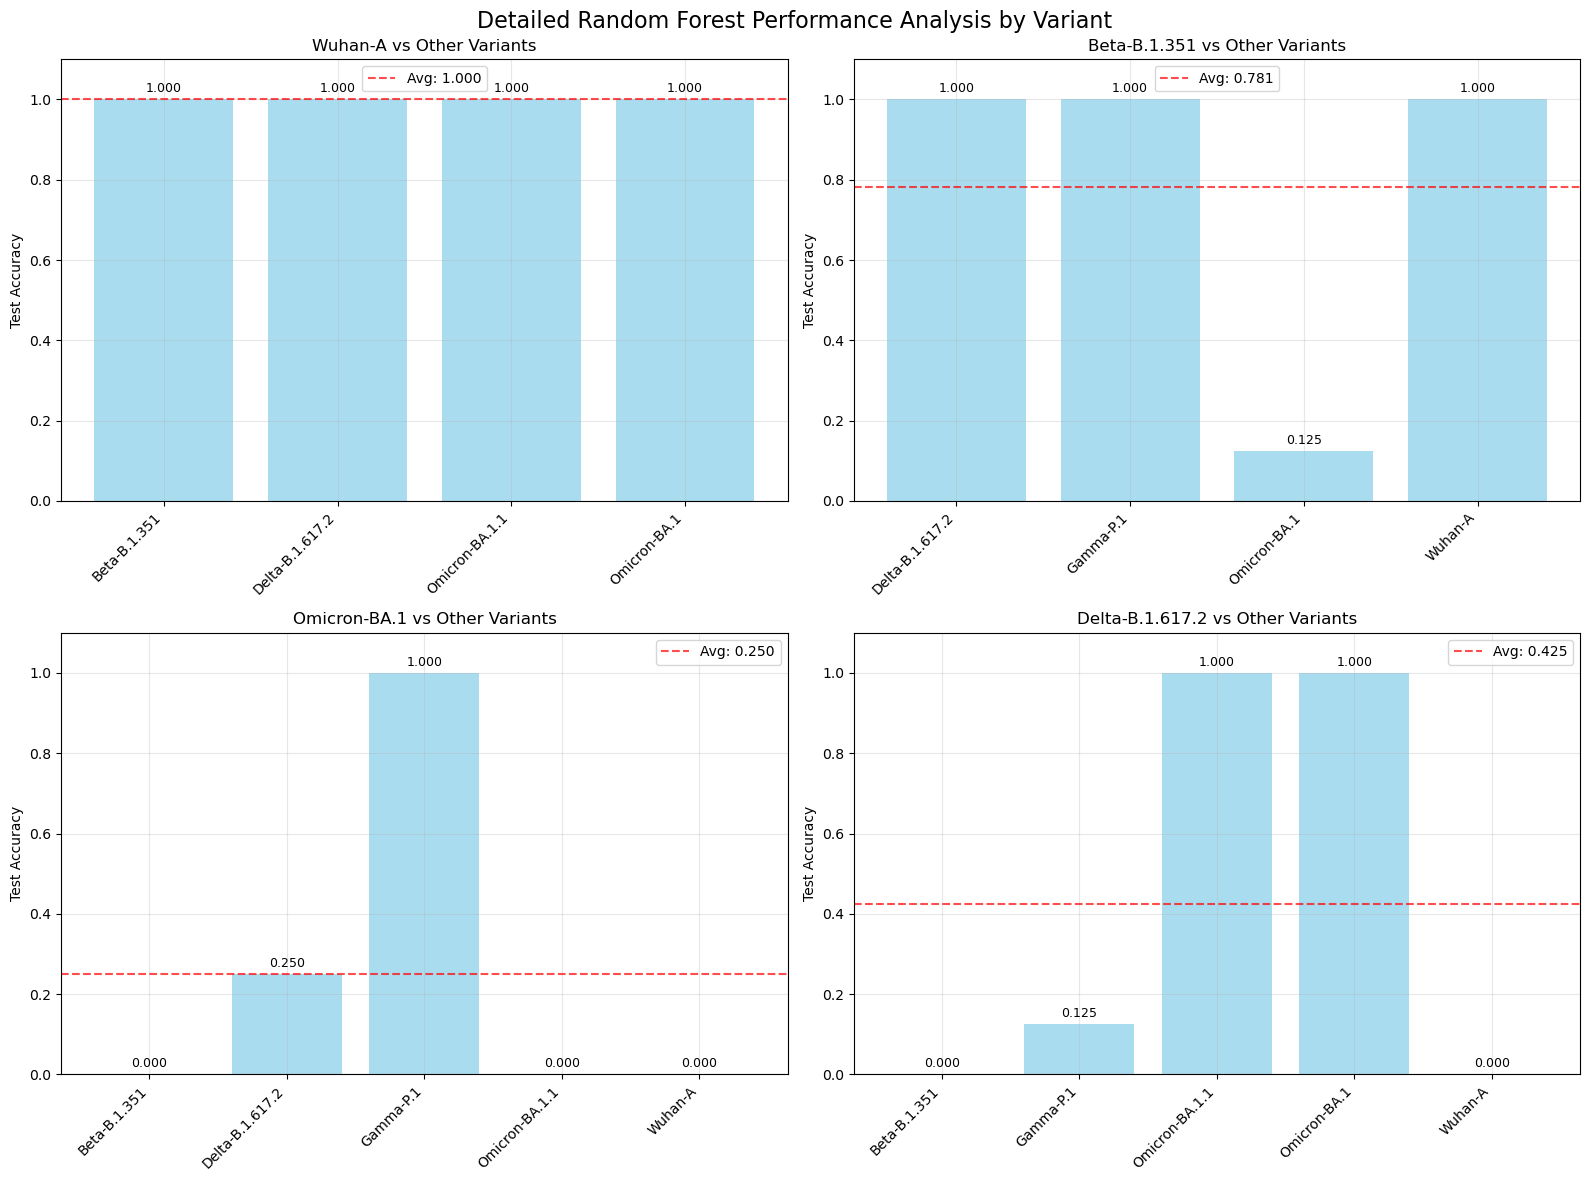


FEATURE IMPORTANCE COMPARISON


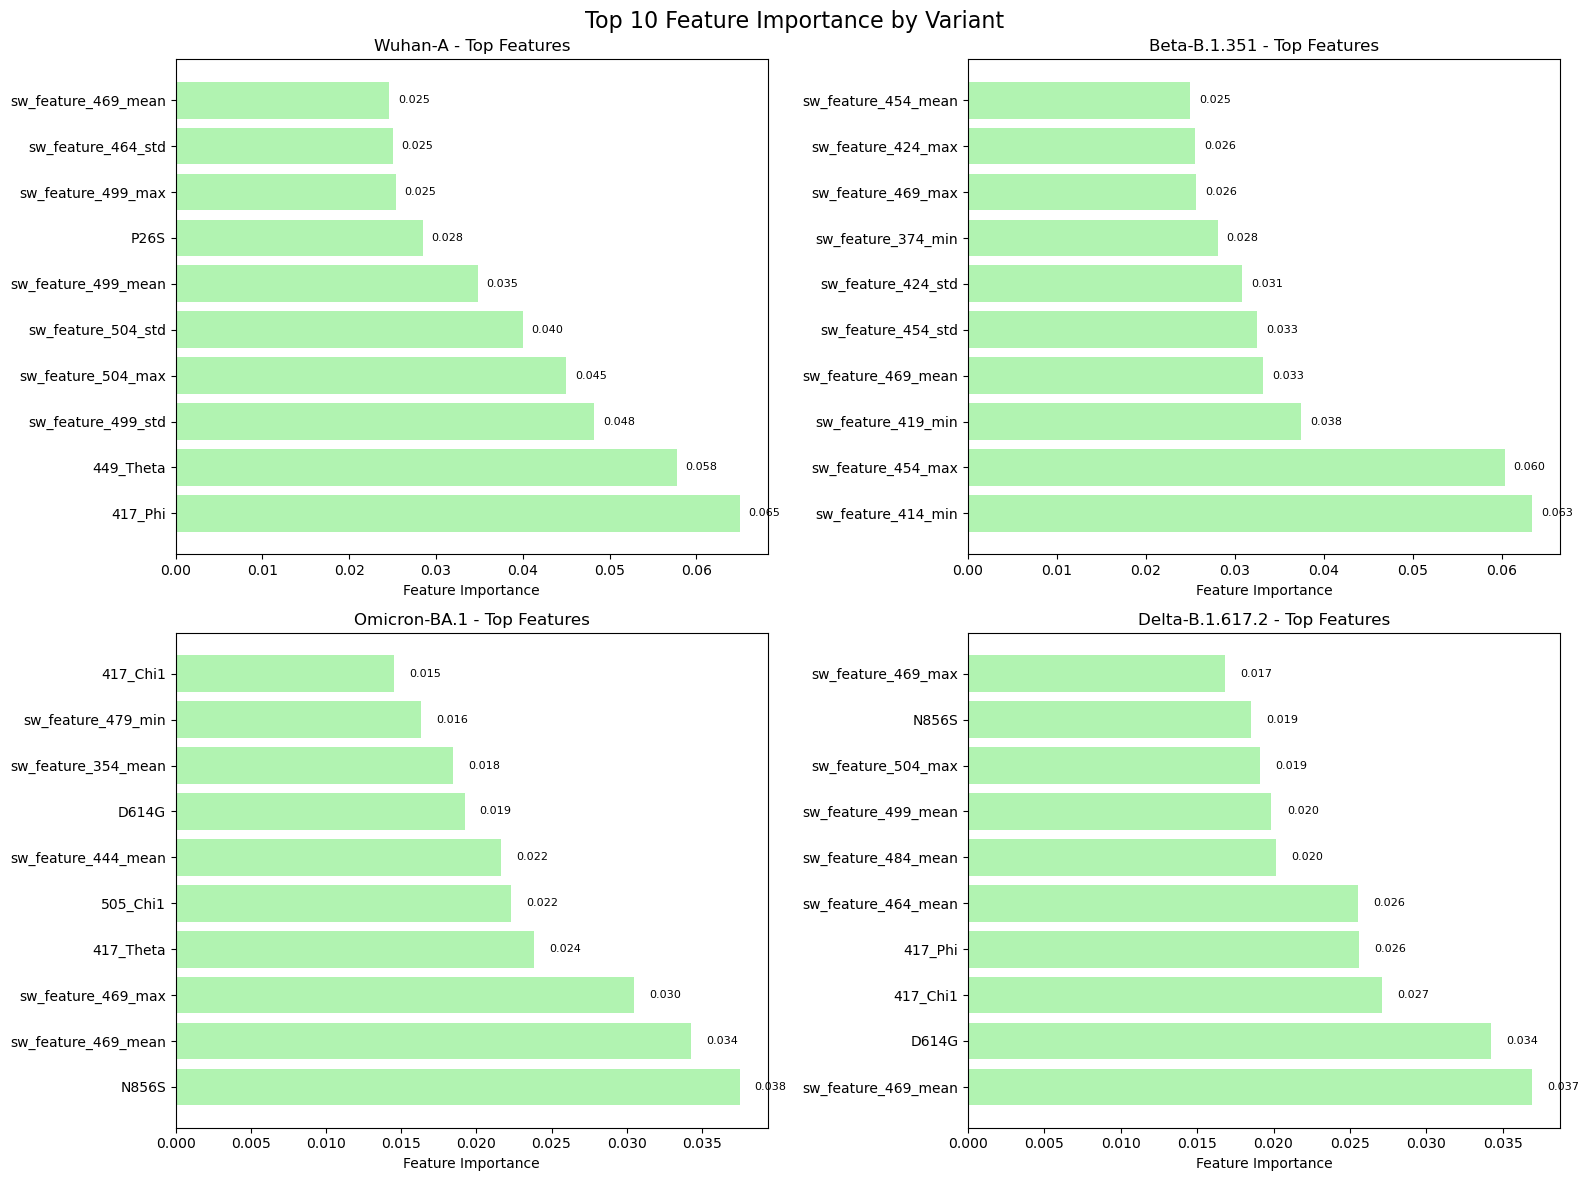


DETAILED STATISTICS FOR SELECTED VARIANTS

Wuhan-A:
------------------------------
Comparison           Accuracy   F1       Precision  Recall   CV          
--------------------------------------------------------------------------------
Beta-B.1.351         1.000      0.000    0.000      0.000    0.970±0.043
Delta-B.1.617.2      1.000      0.000    0.000      0.000    0.970±0.043
Omicron-BA.1.1       1.000      0.000    0.000      0.000    0.970±0.043
Omicron-BA.1         1.000      0.000    0.000      0.000    0.970±0.043

Summary:
  Average Accuracy: 1.000 ± 0.000
  Average F1 Score: 0.000 ± 0.000
  Best Performance: Beta-B.1.351 (Accuracy: 1.000)
  Worst Performance: Omicron-BA.1 (Accuracy: 1.000)

Beta-B.1.351:
------------------------------
Comparison           Accuracy   F1       Precision  Recall   CV          
--------------------------------------------------------------------------------
Delta-B.1.617.2      1.000      0.000    0.000      0.000    0.970±0.043
Gamma-P.1     

In [62]:
# Detailed analysis of selected variants
print("=" * 70)
print("DETAILED VARIANT ANALYSIS")
print("=" * 70)

# Select a few key variants for detailed analysis
selected_variants = ["Wuhan-A", "Beta-B.1.351", "Omicron-BA.1", "Delta-B.1.617.2"]
print(f"Analyzing detailed performance for: {selected_variants}")

# Create detailed visualizations for each selected variant
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Detailed Random Forest Performance Analysis by Variant', fontsize=16)

for idx, variant in enumerate(selected_variants):
    if variant not in combined_df["variant"].unique():
        continue
    
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Get all results for this variant
    variant_results = []
    variant_names = []
    
    for (val_var, comp_var), result in detailed_results.items():
        if val_var == variant:
            variant_results.append(result['test_accuracy'])
            variant_names.append(comp_var)
    
    if variant_results:
        # Create bar plot
        bars = ax.bar(range(len(variant_results)), variant_results, color='skyblue', alpha=0.7)
        ax.set_title(f'{variant} vs Other Variants', fontsize=12)
        ax.set_ylabel('Test Accuracy')
        ax.set_ylim(0, 1.1)
        
        # Add value labels on bars
        for bar, acc in zip(bars, variant_results):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
        
        # Set x-axis labels
        ax.set_xticks(range(len(variant_names)))
        ax.set_xticklabels(variant_names, rotation=45, ha='right')
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Add average line
        avg_acc = np.mean(variant_results)
        ax.axhline(y=avg_acc, color='red', linestyle='--', alpha=0.7, label=f'Avg: {avg_acc:.3f}')
        ax.legend()

plt.tight_layout()
plt.show()

# Feature importance comparison for selected variants
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 70)

# Get top features for each selected variant
top_features_per_variant = {}
for variant in selected_variants:
    if variant not in combined_df["variant"].unique():
        continue
    
    # Aggregate feature importance for this variant across all comparisons
    variant_feature_importance = {}
    count = 0
    
    for (val_var, comp_var), result in detailed_results.items():
        if val_var == variant:
            count += 1
            for idx, importance in enumerate(result['feature_importance']):
                feat_name = feature_columns[idx] if idx < len(feature_columns) else f'feature_{idx}'
                if feat_name not in variant_feature_importance:
                    variant_feature_importance[feat_name] = []
                variant_feature_importance[feat_name].append(importance)
    
    # Calculate average importance
    avg_importance = {feat: np.mean(imps) for feat, imps in variant_feature_importance.items()}
    top_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    top_features_per_variant[variant] = top_features

# Create comparison plot
fig3, axes3 = plt.subplots(2, 2, figsize=(16, 12))
fig3.suptitle('Top 10 Feature Importance by Variant', fontsize=16)

for idx, variant in enumerate(selected_variants):
    if variant not in top_features_per_variant:
        continue
    
    row = idx // 2
    col = idx % 2
    ax = axes3[row, col]
    
    features, importances = zip(*top_features_per_variant[variant])
    
    # Truncate long feature names
    short_features = [feat[:20] + '...' if len(feat) > 20 else feat for feat in features]
    
    bars = ax.barh(range(len(importances)), importances, color='lightgreen', alpha=0.7)
    ax.set_yticks(range(len(short_features)))
    ax.set_yticklabels(short_features)
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'{variant} - Top Features', fontsize=12)
    
    # Add value labels
    for i, (bar, imp) in enumerate(zip(bars, importances)):
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
               f'{imp:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print detailed statistics for selected variants
print("\n" + "=" * 70)
print("DETAILED STATISTICS FOR SELECTED VARIANTS")
print("=" * 70)

for variant in selected_variants:
    if variant not in combined_df["variant"].unique():
        continue
    
    print(f"\n{variant}:")
    print("-" * 30)
    
    variant_stats = []
    for (val_var, comp_var), result in detailed_results.items():
        if val_var == variant:
            variant_stats.append({
                'comparison': comp_var,
                'accuracy': result['test_accuracy'],
                'f1': result['test_f1'],
                'precision': result['test_precision'],
                'recall': result['test_recall'],
                'cv_mean': result['cv_mean'],
                'cv_std': result['cv_std']
            })
    
    if variant_stats:
        # Sort by accuracy
        variant_stats.sort(key=lambda x: x['accuracy'], reverse=True)
        
        print(f"{'Comparison':<20} {'Accuracy':<10} {'F1':<8} {'Precision':<10} {'Recall':<8} {'CV':<12}")
        print("-" * 80)
        
        for stat in variant_stats:
            print(f"{stat['comparison']:<20} {stat['accuracy']:<10.3f} {stat['f1']:<8.3f} "
                  f"{stat['precision']:<10.3f} {stat['recall']:<8.3f} "
                  f"{stat['cv_mean']:.3f}±{stat['cv_std']:.3f}")
        
        # Summary statistics
        accuracies = [stat['accuracy'] for stat in variant_stats]
        f1_scores = [stat['f1'] for stat in variant_stats]
        
        print(f"\nSummary:")
        print(f"  Average Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
        print(f"  Average F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
        print(f"  Best Performance: {variant_stats[0]['comparison']} (Accuracy: {variant_stats[0]['accuracy']:.3f})")
        print(f"  Worst Performance: {variant_stats[-1]['comparison']} (Accuracy: {variant_stats[-1]['accuracy']:.3f})")

## Feature Importance

In [60]:
# Feature importance analysis
print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature names from the dataframe
feature_columns = [col for col in combined_df.columns if col not in ["sequence", "variant"] + ["Against " + var for var in combined_df['variant'].unique()]]
print(f"Total features available: {len(feature_columns)}")
print(f"Feature columns: {feature_columns[:10]}...")  # Show first 10

print("\n" + "-" * 70)
print("FEATURE IMPORTANCE FOR EACH VARIANT PAIR")
print("-" * 70)

# Analyze feature importance for each trained model
for (val_var, comp_var), result in detailed_results.items():
    print("=" * 50)
    print(f"{val_var} vs {comp_var}")
    
    # Get feature importance
    feature_importance = result['feature_importance']
    
    # Get top features
    top_indices = np.argsort(feature_importance)[::-1][:15]
    
    print("Top 15 most important features:")
    print(f"{'Rank':<4} {'Feature':<25} {'Importance':<12}")
    print("-" * 45)
    
    for rank, idx in enumerate(top_indices, 1):
        feat_name = feature_columns[idx] if idx < len(feature_columns) else f'feature_{idx}'
        if len(feat_name) > 22:
            feat_name = feat_name[:22] + "..."
        
        print(f"{rank:<4} {feat_name:<25} {feature_importance[idx]:<12.4f}")
    
    # Interpretation
    print(f"\nInterpretation:")
    print(f"• Most important feature: {feature_columns[top_indices[0]]}")
    print(f"• Top 5 features account for {np.sum(feature_importance[top_indices[:5]])*100:.1f}% of importance")

FEATURE IMPORTANCE ANALYSIS
Total features available: 270
Feature columns: ['D614G', 'N856S', 'G1124V', 'T19R', 'T95I', 'G142D', 'E156G', 'F157-', 'R158-', 'R158G']...

----------------------------------------------------------------------
FEATURE IMPORTANCE FOR EACH VARIANT PAIR
----------------------------------------------------------------------
Wuhan-A vs Beta-B.1.351
Top 15 most important features:
Rank Feature                   Importance  
---------------------------------------------
1    417_Phi                   0.0700      
2    449_Theta                 0.0512      
3    sw_feature_504_std        0.0500      
4    sw_feature_499_std        0.0436      
5    sw_feature_504_max        0.0400      
6    T1027I                    0.0323      
7    sw_feature_479_mean       0.0316      
8    P26S                      0.0314      
9    sw_feature_484_std        0.0300      
10   sw_feature_499_mean       0.0293      
11   T20N                      0.0286      
12   sw_feature_47

## Summary Analysis

In [61]:
# Summary analysis across all models
print(f"\n" + "=" * 70)
print("SUMMARY OF FEATURE IMPORTANCE")
print("=" * 70)

# Aggregate feature importance across all models
all_feature_importance = {}
model_count = 0

for (val_var, comp_var), result in detailed_results.items():
    model_count += 1
    feature_importance = result['feature_importance']
    
    for idx, importance in enumerate(feature_importance):
        feat_name = feature_columns[idx] if idx < len(feature_columns) else f'feature_{idx}'
        if feat_name not in all_feature_importance:
            all_feature_importance[feat_name] = []
        all_feature_importance[feat_name].append(importance)

# Calculate average importance across all models
avg_importance = {}
for feat_name, importance_list in all_feature_importance.items():
    avg_importance[feat_name] = np.mean(importance_list)

# Sort by average importance
sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)

print(f"Average feature importance across {model_count} Random Forest models:")
print(f"{'Rank':<4} {'Feature':<30} {'Avg Importance':<15} {'Frequency':<10}")
print("-" * 70)

for rank, (feat_name, avg_imp) in enumerate(sorted_features[:20], 1):
    frequency = len(all_feature_importance[feat_name])
    feat_display = feat_name if len(feat_name) <= 27 else feat_name[:27] + "..."
    print(f"{rank:<4} {feat_display:<30} {avg_imp:<15.4f} {frequency}/{model_count}")

print(f"\nMost consistently important features:")
for feat_name, avg_imp in sorted_features[:5]:
    frequency = len(all_feature_importance[feat_name])
    print(f"• {feat_name}: avg importance = {avg_imp:.4f} (appears in {frequency}/{model_count} models)")


SUMMARY OF FEATURE IMPORTANCE
Average feature importance across 18 Random Forest models:
Rank Feature                        Avg Importance  Frequency 
----------------------------------------------------------------------
1    sw_feature_469_mean            0.0326          18/18
2    417_Phi                        0.0250          18/18
3    sw_feature_469_max             0.0197          18/18
4    sw_feature_414_min             0.0186          18/18
5    417_Theta                      0.0172          18/18
6    sw_feature_499_mean            0.0169          18/18
7    449_Theta                      0.0160          18/18
8    sw_feature_454_max             0.0159          18/18
9    sw_feature_504_max             0.0159          18/18
10   N856S                          0.0156          18/18
11   D614G                          0.0149          18/18
12   sw_feature_419_min             0.0145          18/18
13   sw_feature_499_std             0.0140          18/18
14   sw_feature_429_st